# <font color = "blue"> Fitting Tumor Reflectance Spectra
<font color = "black"> Diffuse reflectance spectroscopy (DRS) is a probe based technique capable of determining tissue oxygenation and morphology. The tissue of interest is illuminated with visible light (**see figure below**) and the reflected light is used to quantify the underlying light absorbers and scatterers, a combination of which is used for recognition of tissue pathology. However, in order to access meaningful biological parameters, the refleted light should fit with a pre-existing model. This notebook aims to present how this python code uses an inverse lookup table (LUT) model in fitting the collected spectrum in following steps: 

    

* Loading packages
* Changing directory to raw data
* Loading the dataset
* Using the model to fit the raw data
* Minimizing the difference among raw-data and model fit





For additional details of the inverse LUT model, please refer to: [Rajaram et al, JBO, 2008](https://www.spiedigitallibrary.org/journals/Journal-of-Biomedical-Optics/volume-13/issue-5/050501/Lookup-tablebased-inverse-model-for-determining-optical-properties-of-turbid/10.1117/1.2981797.full?SSO=1)

![title](Picture1.tif)

## 1- Loading packages##
Importing required libraries and packages as following:
* [os](https://docs.python.org/3/library/os.path.html) for manipulation of directory and pathname
* [numpy](https://numpy.org/) for fundamental scientific computation
* [scipy](https://www.scipy.org/) for mathematical functions
* [pandas](https://pandas.pydata.org/) for easy-to-use data structures
* [matplotlib](https://matplotlib.org/) for plotting graphs
* [mpl_toolkits](https://matplotlib.org/mpl_toolkits/mplot3d/) for plotting 3D graphs


In [2]:
# Importing required libraroes
import os
import numpy as np
from scipy.interpolate import interp2d
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 2- Directory##
Changing the path to the directory of the folder where the data are stored and getting a list of files within that folder.

In [3]:
dir =  r"C:\Users\krraz\Desktop\sd\tumor_data"
%cd -q $dir
dirs = os.listdir(dir)
# Defining directory,changing it & getting a list of files in the directory

## 3- Loading Dataset##
Loading all of the csv files and calculating reflectance according to the equation: $ R = \frac{out - out_{bgd}}{(in - in_{bgd})*0.8} $

In [4]:
grads = []
for i in range(len(dirs)):
    intensity = pd.read_csv(dirs[i], header = None, usecols = [1])
    grads.append(intensity)
data = pd.concat(grads, axis = 1)
wavlength = pd.read_csv('A_.csv', header = None, usecols = [0])
# Reading all of the csv files and concatenating them to one matrix

numerator   =  data.iloc[:, 0] - data.iloc[:, 1]
denominator = (data.iloc[:,-2] - data.iloc[:,-1]) * 0.8
# subtracting the background noise
reflectance = numerator / denominator
# calculating the reflectance according to equation above

Plotting the raw reflectance as a function of wavelength. This is the curve that we will fit using our model.

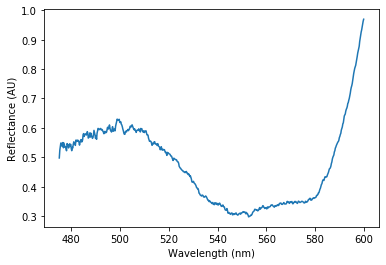

In [5]:
plt.plot(wavlength, reflectance)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (AU)')
plt.show()
# plotting spectra of Hbo2, dHb, & mel

## 4- Loading LUT files##
Changing the directory again to the folder where the LUT files are located at and loading all LUT-related files.

In [6]:
lutdir = r"C:\Users\krraz\Desktop\sd\LUT_files"
%cd -q $lutdir
# chaning the directory to where the Lookup table is located at

dHb  = (pd.read_csv('eHb.csv', header = None, usecols = [1])).values
HbO2 = (pd.read_csv('eHbO2.csv', header = None, usecols = [1])).values
mel  = (pd.read_csv('emel.csv',  header = None, usecols = [1])).values
wavelength = (pd.read_csv('Wavelength.csv', header = None, usecols = [0])).values
mu_a_table  = (pd.read_csv('mua350.csv' , header = None, usecols = [0])).values
mu_sp_table = (pd.read_csv('musp_75.csv', header = None, usecols = [0])).values
LUT = (pd.read_csv('table2.csv', header = None)).values
# loading LUT files & Converting panda files to numpy arrays

#### LUT in a nutshell
Briefly, the LUT is a 3D grid of absoorption, scattering, and their correponding unique reflectance value. This means that by knowing absorption and scattering of a tumor, we can gain access to its reflectance value (**See figure below and refer to [Rajaram et al, JBO, 2008](https://www.spiedigitallibrary.org/journals/Journal-of-Biomedical-Optics/volume-13/issue-5/050501/Lookup-tablebased-inverse-model-for-determining-optical-properties-of-turbid/10.1117/1.2981797.full?SSO=1) for more information**).

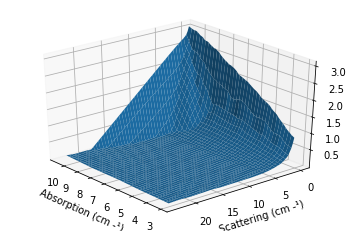

In [7]:
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
# enable printing subscript & superscirpts

fig  = plt.figure()
ax   = fig.gca(projection = '3d')
surf = ax.plot_surface(mu_sp_table.T, mu_a_table, LUT)
ax.set_xlabel('Absorption (cm -1)'.translate(SUP))
ax.set_ylabel('Scattering (cm -1)'.translate(SUP))
ax.set_zlabel('Reflectance (AU)');
ax.view_init(elev = 30, azim = 140)
plt.show()
# plotting the LUT



## 5- Defining two new functions##
----- ----- ----- ----- ----- ----- ----- 
### 5.1 calcZonios

i. Based on **initial** values of A, B, C, S, and M, one we can calculate $\mu_s'$ ane $\mu_a$ using equations:

<br>
$$\mu_s' = 10 * A (\frac{wavelength}{600})^{-B}$$

<br>
$$\mu_a = 2.303 * C [S * HbO_2(\lambda) + (1-S) * dHb(\lambda)] + M * mel(\lambda)$$

<br>
ii. Now that $\mu_s'$ ane $\mu_a$ are known, we can use the LUT (figure above) to interpolate for their corresponding reflectance value. 

<br>

iii. Once the Fit has been determined, the error rate among the expected (fit) and extracted dataset is calculated based on:

<br>

$$\chi^2 = \Sigma(\frac{R_{expected} - R_{extracted}}{R_{extracted}})^2$$


In [8]:
def calcZonios(InitVal, R_extracted, dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT):
    """
    calcZonios computes the fit based on extracted spectrum and input values

    Arguments:
    InitVal      -- A (1x5) array of initial values
    R_extracted  -- A (601x1) array is the spectrum that is going to be Fit
    dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT -- Are (601x1) arrays to be used in curve fitting algorithm

    Returns:
    chisq -- Chi-sqaure error between measured spectrum and the model fit
    """
    A = InitVal[0]
    B = InitVal[1]
    M = InitVal[2]
    C = InitVal[3]
    S = InitVal[4]
    # Unpacking initiall values

    mu_a  = 2.303 * C * (S * HbO2 + (1 - S) * dHb) + M * mel
    mu_sp = A * 10 * np.power(wavelength / 600, -B)
    # Calculating absorption and scattering of light based on initial values

    f = interp2d(mu_sp_table.T, mu_a_table, LUT, kind = 'linear')
    # Creating a 2-D interpolative model based on known absorption and scattering properties

    R_expected = np.array([])
    for i in range(len(mu_a)):
        int = f(mu_sp[i],mu_a[i])
        R_expected = np.append(R_expected, int)
    # Interpolating tumor values based on generated model

    chisq = np.sum(np.power((R_expected - R_extracted) / R_extracted, 2))
    # Calculating the chi-square error between the raw tumor spectrum and generated fit

    return chisq

### 5.1 calcR

Once the true values of A, B, M, C, and S are finalized, this function returns the closest fit of the data.


In [9]:
def calcR(opt_vals, dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT):
    """
    calcR computes the final fit of the model to raw data based on optimized parameters

    Arguments:
    opt_vals      -- A (1x5) array of optimized values
    dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT -- Are (601x1) arrays to be used in curve fitting algorithm

    Returns:
    model_fit -- Chi-sqaure error between measured spectrum and the model fit
    """
    A = opt_vals[0]
    B = opt_vals[1]
    M = opt_vals[2]
    C = opt_vals[3]
    S = opt_vals[4]
    # Unpacking optimized values

    mu_a  = 2.303 * C * (S * HbO2 + (1 - S) * dHb) + M * mel
    mu_sp = A * 10 * np.power(wavelength / 600, -B)
    # Calculating absorption and scattering of light based on initial values

    f = interp2d(mu_sp_table.T, mu_a_table, LUT, kind='linear')
    # Creating a 2-D interpolative model based on known absorption and scattering properties

    model_fit = np.array([])
    for i in range(len(mu_a)):
        int = f(mu_sp[i],mu_a[i])
        model_fit = np.append(model_fit, int)
        # Interpolating tumor values based on generated model

    return model_fit

## 6- Minimizing Error among Expected and Extracted values##
Here, scipy minimize function is used to minimize the output of the dunction calcZonios with initial values for A, B, M, C, and S. THe free parameters are changed within defined bounds.

In [10]:
args = (reflectance, dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT)
# Combining all of the LUT-related parameters into a tuple
InitVal  = np.array([0.75, 1.1, 1, 1, 0.85])
x_bounds = [[0.2, 1.5], [0, 1.4], [2, 3], [0.05, 7], [0, 1]]
# defining initial values to start & bounds

solution = minimize(calcZonios, InitVal, args = (reflectance, dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT), method = 'SLSQP', bounds = x_bounds, options = {'ftol': 1e-8, 'maxiter': 2000, 'disp': False})

print("Best value for parameter A is: " + str(solution.x[0]))
print("Best value for parameter B is: " + str(solution.x[1]))
print("Best value for parameter M is: " + str(solution.x[2]))
print("Best value for parameter C is: " + str(solution.x[3]))
print("Best value for parameter S is: " + str(solution.x[4]))
print("Chi-squared error of these parameters is: " + str(solution.fun))

Best value for parameter A is: 0.6392428033728913
Best value for parameter B is: 1.4
Best value for parameter M is: 2.0
Best value for parameter C is: 1.3374643565338664
Best value for parameter S is: 0.2721550784275599
Chi-squared error of these parameters is: 4.584386700729199


Now that the parameters are set to their final values, they are used to reconstruct the fit.

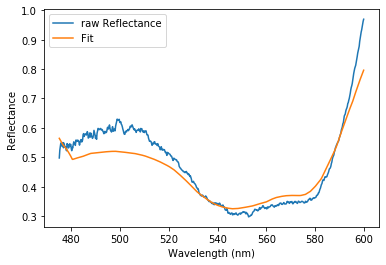

In [13]:
fit = calcR(solution.x, dHb, HbO2, mel, wavelength, mu_a_table, mu_sp_table, LUT)
plt.plot(wavelength, reflectance, label = 'raw Reflectance' )
plt.plot(wavelength, fit, label = 'Fit' )
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()